In [1]:
import os
import tensorflow as tf
from transformers import *

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import gluonnlp as nlp
from gluonnlp.data import SentencepieceTokenizer

import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
import numpy as np
import re

import setGPU

I0512 15:48:23.054007 139913215973184 file_utils.py:38] PyTorch version 1.4.0 available.
I0512 15:48:23.055145 139913215973184 file_utils.py:54] TensorFlow version 2.1.0 available.


setGPU: Setting GPU to: 1


In [2]:
# 시각화

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [3]:
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)

In [4]:
class TFGPT2Classifier(tf.keras.Model):
    def __init__(self, dir_path=None, num_class=None):
        super(TFGPT2Classifier, self).__init__()
        
        self.dir_path = 'gpt2' if dir_path is None else dir_path
        
        self.gpt2 = TFGPT2Model.from_pretrained(self.dir_path)
        self.num_class = self.gpt2.config.num_labels if num_class is None else num_class
        
        self.dropout = tf.keras.layers.Dropout(self.gpt2.config.summary_first_dropout)
        self.classifier = tf.keras.layers.Dense(self.num_class, 
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=self.gpt2.config.initializer_range), 
                                                name="classifier")
        
    def call(self, inputs):
        outputs = self.gpt2(inputs)
        pooled_output = outputs[0][:, -1]

        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        outputs = (logits,) + outputs[2:] 

        return outputs

In [5]:
TOKENIZER_PATH = './gpt_ckpt/kogpt2_news_wiki_ko_cased_818bfa919d.spiece'

tokenizer = SentencepieceTokenizer(TOKENIZER_PATH)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(TOKENIZER_PATH,
                                               mask_token=None,
                                               sep_token='<unused0>',
                                               cls_token='<unused1>',
                                               unknown_token='<unk>',
                                               padding_token='<pad>',
                                               bos_token='<s>',
                                               eos_token='</s>')

In [6]:
#random seed 고정

tf.random.set_seed(0)
np.random.seed(0)

BATCH_SIZE = 384
NUM_EPOCHS = 20
VALID_SPLIT = 0.1
MAX_LEN = 39
DATA_IN_PATH = 'data_in/KOR'
DATA_OUT_PATH = "data_out/KOR"

In [94]:
# 데이터 전처리 준비

DATA_TRAIN_PATH = os.path.join(DATA_IN_PATH, "naver_movie", "ratings_train.txt")
DATA_TEST_PATH = os.path.join(DATA_IN_PATH, "naver_movie", "ratings_test.txt")

train_data = pd.read_csv(DATA_TRAIN_PATH, header = 0, delimiter = '\t', quoting = 3)
train_data = train_data.dropna()
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [ ]:
# 텍스트 전처리

def clean_text(sent):
    sent_clean = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", "", sent)
    return sent_clean

In [112]:
# train_data = train_data[:1000] # for test

train_data_sents = list()
train_data_labels = list()

for train_sent, train_label in zip(train_data['document'], train_data['label']):
    tokens = [vocab[vocab.bos_token],]  + vocab[tokenizer(clean_text(train_sent))] + [vocab[vocab.eos_token],]
    train_data_sents.append(tokens)
    train_data_labels.append(train_label)

train_data_sents = pad_sequences(train_data_sents, MAX_LEN - 1, value=vocab[vocab.padding_token])#, padding='post')
cls_tokens = [[vocab[vocab.cls_token]]] * train_data_sents.shape[0]

train_data_sents = np.concatenate((train_data_sents, cls_tokens), axis=-1)

train_data_sents = np.array(train_data_sents, dtype=np.int64)
train_data_labels = np.array(train_data_labels, dtype=np.int64)

In [97]:
cls_model = TFGPT2Classifier('./gpt_ckpt')

I0511 14:52:27.259068 140232862971712 configuration_utils.py:252] loading configuration file ./gpt_ckpt/config.json
I0511 14:52:27.260537 140232862971712 configuration_utils.py:290] Model config GPT2Config {
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": null,
  "do_sample": false,
  "embd_pdrop": 0.1,
  "eos_token_ids": null,
  "finetuning_task": null,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "is_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_norm_epsilon": 1e-05,
  "length_penalty": 1.0,
  "max_length": 20,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_layer": 12,
  "n_positions": 1024,
  "num_beams": 1,
  "num_labels": 2,
  "num_return_sequences": 1,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pad_token_id": null,
  "pruned_heads": {},
  "repetition_penalty": 1.0,
  "resid_pdrop": 0.

In [108]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
cls_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [113]:
model_name = "tf2_gpt2_naver_movie"

earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001,patience=2)

checkpoint_path = os.path.join(DATA_OUT_PATH, model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

history = cls_model.fit(train_data_sents, train_data_labels, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE,
                    validation_split = VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])

data_out/KOR/tf2_gpt2_naver_movie -- Folder already exists 

Train on 134995 samples, validate on 15000 samples
Epoch 1/20
134784/134995 [============================>.] - ETA: 0s - loss: 0.0953 - accuracy: 0.9631
Epoch 00001: val_accuracy improved from -inf to 0.89213, saving model to data_out/KOR/tf2_gpt2_naver_movie/weights.h5
134995/134995 [==============================] - 366s 3ms/sample - loss: 0.0953 - accuracy: 0.9631 - val_loss: 0.3810 - val_accuracy: 0.8921
Epoch 2/20
134784/134995 [============================>.] - ETA: 0s - loss: 0.0733 - accuracy: 0.9719
Epoch 00002: val_accuracy did not improve from 0.89213
134995/134995 [==============================] - 355s 3ms/sample - loss: 0.0732 - accuracy: 0.9719 - val_loss: 0.4095 - val_accuracy: 0.8916
Epoch 3/20
134784/134995 [============================>.] - ETA: 0s - loss: 0.0596 - accuracy: 0.9768
Epoch 00003: val_accuracy did not improve from 0.89213
134995/134995 [==============================] - 355s 3ms/sample - loss:

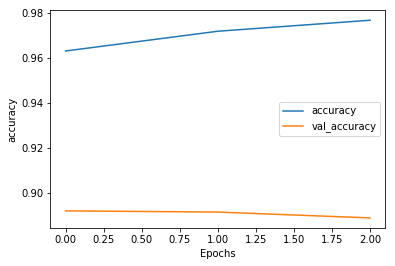

In [120]:
plot_graphs(history, 'accuracy')

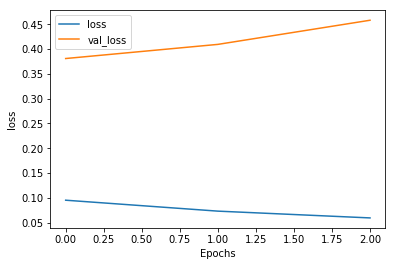

In [121]:
plot_graphs(history, 'loss')

# Bag of Words Test Dataset (제출 확인 필요)

In [116]:
test_data = pd.read_csv(DATA_TEST_PATH, header = 0, delimiter = '\t', quoting = 3)
test_data = test_data.dropna()
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [117]:
# test_data = test_data[:50] # for test

test_data_sents = list()
test_data_labels = list()

for test_sent, test_label in zip(test_data['document'], test_data['label']):
    tokens = [vocab[vocab.bos_token],]  + vocab[tokenizer(clean_text(test_sent))] + [vocab[vocab.eos_token],]
    test_data_sents.append(tokens)
    test_data_labels.append(test_label)

test_data_sents = pad_sequences(test_data_sents, MAX_LEN - 1, value=vocab[vocab.padding_token])#, padding='post')
cls_tokens = [[vocab[vocab.cls_token]]] * test_data_sents.shape[0]

test_data_sents = np.concatenate((test_data_sents, cls_tokens), axis=-1)

test_data_sents = np.array(test_data_sents, dtype=np.int64)
test_data_labels = np.array(test_data_labels, dtype=np.int64)

In [118]:
print("num sents, labels {}, {}".format(len(test_data_sents), len(test_data_labels)))

num sents, labels 49997, 49997


In [119]:
results = cls_model.evaluate(test_data_sents, test_data_labels, batch_size=1024)
print("test loss, test acc: ", results)

49997/49997 [==============================] - 44s 883us/sample - loss: 0.4703 - accuracy: 0.8863
test loss, test acc:  [0.4702860292236593, 0.8863132]


# KoNLI Simliarity 

In [7]:
BATCH_SIZE = 128
NUM_EPOCHS = 20
VALID_SPLIT = 0.2
MAX_LEN = 80 # Average total * 2

In [9]:
# Load Train dataset

TRAIN_SNLI_DF = os.path.join(DATA_IN_PATH, 'KorNLI', 'snli_1.0_train.kor')
TRAIN_XNLI_DF = os.path.join(DATA_IN_PATH, 'KorNLI', 'multinli.train.ko.tsv')
DEV_XNLI_DF = os.path.join(DATA_IN_PATH, 'KorNLI', 'xnli.dev.ko.tsv')

train_data_snli = pd.read_csv(TRAIN_SNLI_DF, header=0, delimiter = '\t', quoting = 3)
train_data_xnli = pd.read_csv(TRAIN_XNLI_DF, header=0, delimiter = '\t', quoting = 3)
dev_data_xnli = pd.read_csv(DEV_XNLI_DF, header=0, delimiter = '\t', quoting = 3)

train_data_snli_xnli = train_data_snli.append(train_data_xnli)
train_data_snli_xnli = train_data_snli_xnli.dropna()
train_data_snli_xnli = train_data_snli_xnli.reset_index()

dev_data_xnli = dev_data_xnli.dropna()

print("Total # dataset: train - {}, dev - {}".format(len(train_data_snli_xnli), len(dev_data_xnli)))

Total # dataset: train - 942808, dev - 2490


In [10]:
# train_data_snli_xnli = train_data_snli_xnli[:50] # for test

# 토크나이저를 제외하고는 5장에서 처리한 방식과 유사하게 접근
def clean_text(sent):
    sent_clean = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", " ", sent)
    return sent_clean

train_data_sents = list()

for train_sent_1, train_sent_2 in zip(train_data_snli_xnli['sentence1'], train_data_snli_xnli['sentence2']):
    tokens = [vocab[vocab.bos_token],]  + vocab[tokenizer(clean_text(train_sent_1))] + \
    [vocab[vocab.eos_token], vocab[vocab.sep_token], vocab[vocab.bos_token]] + \
    vocab[tokenizer(clean_text(train_sent_2))] + [vocab[vocab.eos_token], vocab[vocab.cls_token]]
    
    train_data_sents.append(tokens)
train_data_sents = pad_sequences(train_data_sents, MAX_LEN, value=vocab[vocab.padding_token])

train_data_sents = np.array(train_data_sents, dtype=np.int64)

In [11]:
train_data_sents[0]

array([    3,     3,     3,     3,     3,     3,     3,     3,     3,
           3,     3,     3,     3,     3,     3,     3,     3,     3,
           3,     3,     3,     3,     3,     3,     3,     3,     3,
           3,     3,     3,     3,     3,     3,     3,     3,     3,
           3,     3,     3,     3,     3,     3,     3,     3,     3,
           3,     3,     3,     3,     3,     3,     3,     3,     3,
           3,     3,     0,  3214,   996,  2373, 13952, 47612, 16540,
        5886,  3564, 47531,  4394,     1, 48140,     0,   118,  2373,
        9442,   264,  3214,  2777,  4106,   123,     1, 47810])

In [12]:
# dev_data_xnli = dev_data_xnli[:50] # for test

dev_data_sents = list()

for dev_sent_1, dev_sent_2 in zip(dev_data_xnli['sentence1'], dev_data_xnli['sentence2']):
    tokens = [vocab[vocab.bos_token],]  + vocab[tokenizer(clean_text(dev_sent_1))] + \
    [vocab[vocab.eos_token], vocab[vocab.sep_token], vocab[vocab.bos_token]] + \
    vocab[tokenizer(clean_text(dev_sent_2))] + [vocab[vocab.eos_token], vocab[vocab.cls_token]]
    
    dev_data_sents.append(tokens)

dev_data_sents = pad_sequences(dev_data_sents, MAX_LEN, value=vocab[vocab.padding_token])

dev_data_sents = np.array(dev_data_sents, dtype=np.int64)

In [13]:
# Label을 Netural, Contradiction, Entailment 에서 숫자 형으로 변경한다.
label_dict = {"entailment": 0, "contradiction": 1, "neutral": 2}
def convert_int(label):
    num_label = label_dict[label]    
    return num_label

train_data_snli_xnli["gold_label_int"] = train_data_snli_xnli["gold_label"].apply(convert_int)
train_data_labels = np.array(train_data_snli_xnli['gold_label_int'], dtype=int)

dev_data_xnli["gold_label_int"] = dev_data_xnli["gold_label"].apply(convert_int)
dev_data_labels = np.array(dev_data_xnli['gold_label_int'], dtype=int)

print("# train labels: {}, #dev labels: {}".format(len(train_data_labels), len(dev_data_labels)))

# train labels: 942808, #dev labels: 2490


In [14]:
sim_model = TFGPT2Classifier('./gpt_ckpt', 3)

I0512 15:50:31.895086 139913215973184 configuration_utils.py:252] loading configuration file ./gpt_ckpt/config.json
I0512 15:50:31.896768 139913215973184 configuration_utils.py:290] Model config GPT2Config {
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": null,
  "do_sample": false,
  "embd_pdrop": 0.1,
  "eos_token_ids": null,
  "finetuning_task": null,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "is_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_norm_epsilon": 1e-05,
  "length_penalty": 1.0,
  "max_length": 20,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_layer": 12,
  "n_positions": 1024,
  "num_beams": 1,
  "num_labels": 2,
  "num_return_sequences": 1,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pad_token_id": null,
  "pruned_heads": {},
  "repetition_penalty": 1.0,
  "resid_pdrop": 0.

In [15]:
optimizer = tf.keras.optimizers.Adam(1e-4)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
sim_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [17]:
model_name = "tf2_gpt_kornli"

earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001,patience=2)

checkpoint_path = os.path.join(DATA_OUT_PATH, model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

history = sim_model.fit(train_data_sents, train_data_labels, epochs=NUM_EPOCHS,
                        validation_data = (dev_data_sents, dev_data_labels),
            batch_size=BATCH_SIZE, callbacks=[earlystop_callback, cp_callback])

data_out/KOR/tf2_gpt_kornli -- Folder already exists 

Train on 942808 samples, validate on 2490 samples
Epoch 1/20
942720/942808 [============================>.] - ETA: 0s - loss: 0.2142 - accuracy: 0.9216
Epoch 00001: val_accuracy improved from -inf to 0.76185, saving model to data_out/KOR/tf2_gpt_kornli/weights.h5
942808/942808 [==============================] - 5095s 5ms/sample - loss: 0.2142 - accuracy: 0.9216 - val_loss: 0.8273 - val_accuracy: 0.7618
Epoch 2/20
942720/942808 [============================>.] - ETA: 0s - loss: 0.1851 - accuracy: 0.9328
Epoch 00002: val_accuracy did not improve from 0.76185
942808/942808 [==============================] - 5111s 5ms/sample - loss: 0.1851 - accuracy: 0.9328 - val_loss: 0.9271 - val_accuracy: 0.7538
Epoch 3/20
942720/942808 [============================>.] - ETA: 0s - loss: 0.1610 - accuracy: 0.9414
Epoch 00003: val_accuracy did not improve from 0.76185
942808/942808 [==============================] - 5117s 5ms/sample - loss: 0.1610 - 

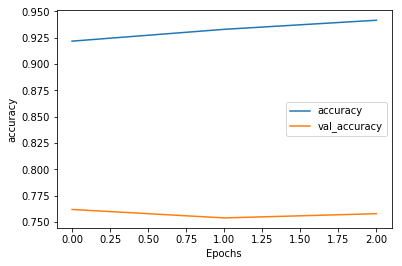

In [24]:
plot_graphs(history, 'accuracy')

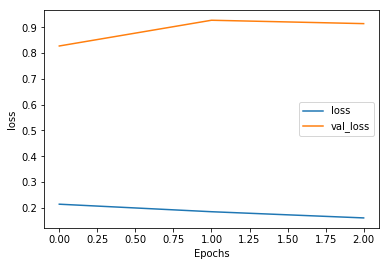

In [25]:
plot_graphs(history, 'loss')

# Quora Simliarity TEST

In [20]:
# Load Test dataset
TEST_XNLI_DF = os.path.join(DATA_IN_PATH, 'KorNLI', 'xnli.test.ko.tsv')

test_data_xnli = pd.read_csv(TEST_XNLI_DF, header=0, delimiter = '\t', quoting = 3)

In [21]:
# test_data_xnli = test_data_xnli[:50] # for test

test_data_sents = list()
# test_data_sent_1 = list()
# test_data_sent_2 = list()

for test_sent_1, test_sent_2 in zip(test_data_xnli['sentence1'], test_data_xnli['sentence2']):
    tokens = [vocab[vocab.bos_token],]  + vocab[tokenizer(clean_text(test_sent_1))] + \
    [vocab[vocab.eos_token], vocab[vocab.sep_token], vocab[vocab.bos_token]] + \
    vocab[tokenizer(clean_text(test_sent_2))] + [vocab[vocab.eos_token], vocab[vocab.cls_token]]
    
    test_data_sents.append(tokens)
    
#     test_data_sent_1.append(vocab[tokenizer(clean_text(test_sent_1))])
#     test_data_sent_2.append(vocab[tokenizer(clean_text(test_sent_2))])

test_data_sents = pad_sequences(test_data_sents, MAX_LEN, value=vocab[vocab.padding_token])
# test_data_sent_1 = pad_sequences(test_data_sent_1, MAX_LEN // 2, value=vocab[vocab.padding_token])#, padding='post')
# test_data_sent_2 = pad_sequences(test_data_sent_2, MAX_LEN // 2, value=vocab[vocab.padding_token])#, padding='post')

# bos_tokens = np.asarray([[vocab[vocab.bos_token]]] * test_data_sent_1.shape[0], dtype=np.int64)
# eos_tokens = np.asarray([[vocab[vocab.eos_token]]] * test_data_sent_1.shape[0], dtype=np.int64)
# sep_tokens = np.asarray([[vocab[vocab.sep_token]]] * test_data_sent_1.shape[0], dtype=np.int64)
# cls_tokens = np.asarray([[vocab[vocab.cls_token]]] * test_data_sent_1.shape[0], dtype=np.int64)

# test_data_sents = np.concatenate((bos_tokens, test_data_sent_1, eos_tokens, sep_tokens, 
#                                    bos_tokens, test_data_sent_2, eos_tokens, cls_tokens), axis=-1)

test_data_sents = np.array(test_data_sents, dtype=np.int64)

In [22]:
test_data_xnli["gold_label_int"] = test_data_xnli["gold_label"].apply(convert_int)
test_data_labels = np.array(test_data_xnli['gold_label_int'], dtype=int)

print("# sents: {}, # labels: {}".format(len(test_data_sents), len(test_data_labels)))

# sents: 5010, # labels: 5010


In [26]:
results = sim_model.evaluate(test_data_sents, test_data_labels)
print("test loss, test acc: ", results)

5010/5010 [==============================] - 10s 2ms/sample - loss: 0.8581 - accuracy: 0.7629
test loss, test acc:  [0.8580960162385495, 0.76287425]


# Valid 0.1 Set으로 진행

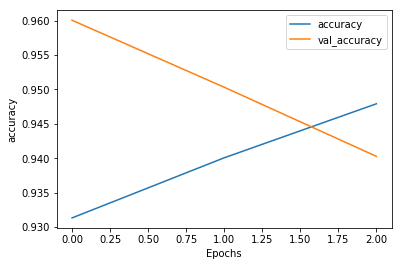

In [48]:
plot_graphs(history, 'accuracy')

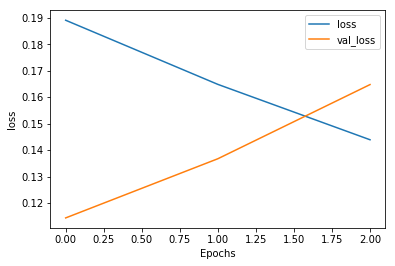

In [49]:
plot_graphs(history, 'loss')

In [47]:
results = sim_model.evaluate(test_data_sents, test_data_labels)
print("test loss, test acc: ", results)

5010/5010 [==============================] - 11s 2ms/sample - loss: 0.9831 - accuracy: 0.7591
test loss, test acc:  [0.9831202033988968, 0.75908184]
